In this project we take the electric demand (power) of clients in Portugal, during 2013 and 2014, and use clustering techniques on their behaviour. There are two parts, first we group clients into clusters using their average consumption (normalized) over the two years, and in the second part we observe the usage of a single client.

The data contains 370 columns of time series, corresponding to the electric demand in 15 minute intervals for 370 clients, between 2011 and 2014. 

data scource:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#


### Data Prep

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)

In [2]:
fileName = 'LD2011_2014.txt'


# In Portugal, decimals are written with a comma "," instead of a period "."
# So as we import the data, we replace "," by "." so the numbers will be in the form 2.3445 instead of 2,3445
import fileinput

with fileinput.FileInput(fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

        

# Create dataframe
import pandas as pd
data = pd.read_csv(fileName, sep=";", index_col=0)

### Quick data inspection

In [3]:
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.tail(5)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [5]:
data.shape

(140256, 370)

Looking at the beginning and end of the dataframe, the index is a timestamp of the end of 15 minute intervals between January 1, 2011 and December 31, 2014. It begins with tons of 0s, the link to the data source explains that those columns were clients that hadn't started yet.

data.shape is consistent with the frequency. Since the frequency is 15 minutes, each day provides 24 x 4 = 96 datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: 96 x 365 x 4 + 96 = 140256

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [7]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

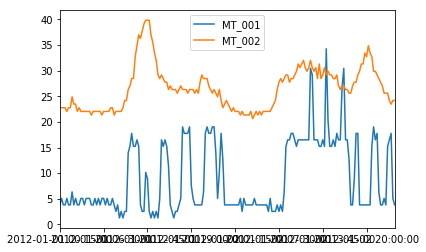

In [8]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

The main difference between the curves is the level (also seen on the means in data.describe()), so we can try to normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We decided to focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [9]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [10]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [11]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [12]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


### Getting average curves per client

In [13]:
data = data_13_14.copy() # weekdays + weekends of data2013, data2014

In [14]:
data['hour'] = data.index.map(lambda x: x[11:]) # this grabs only the time from our datetime index

In [15]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [16]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

The dataframe average_curves contains 349 typical electric demands, aka 349 clients

We now divide each curve by its mean, so that all curves have mean 1 and have the same magnitude

In [17]:
average_curves_norm = average_curves/(average_curves.mean())

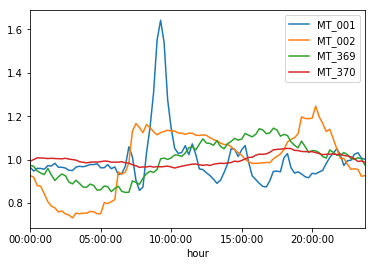

In [18]:
# Plot the first 2 and last 2 clients

average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [19]:
X = average_curves_norm.copy()
X = np.array(X.T) # transpose to put it on the right format

In [20]:
average_curves_norm

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,...,0.414676,0.748555,0.561491,0.430085,0.471574,1.358632,1.215272,1.170441,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,...,0.414381,0.662602,0.412336,0.375704,0.423108,1.365299,1.184899,1.223818,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,...,0.386706,0.561815,0.395294,0.344682,0.386975,1.312627,1.177781,1.211343,0.947969,1.008515
00:45:00,0.959434,0.877243,0.971708,1.030153,1.053960,0.868064,1.056382,0.855331,0.907404,0.885073,...,0.337499,0.499651,0.352628,0.295219,0.377024,1.245171,1.156699,1.189829,0.937889,1.007613
01:00:00,0.956085,0.841989,0.953443,0.975761,1.024347,0.822656,1.030838,0.830275,0.888265,0.869041,...,0.318475,0.422753,0.342066,0.288892,0.369187,1.292298,1.149629,1.167326,0.931284,1.006770
01:15:00,0.972494,0.806701,0.949181,0.920906,0.992994,0.799565,1.003195,0.809026,0.873830,0.857623,...,0.308544,0.392267,0.307168,0.282864,0.360015,1.246425,1.139513,1.105127,0.959546,1.005071
01:30:00,0.970485,0.786076,0.954660,0.897345,0.962757,0.783898,0.991182,0.789147,0.857386,0.837437,...,0.302172,0.376075,0.303887,0.279623,0.355428,1.221937,1.125489,0.993529,0.929746,1.006327
01:45:00,0.983211,0.778034,0.947354,0.875850,0.934785,0.755104,0.981851,0.769917,0.844550,0.820539,...,0.294633,0.369963,0.301034,0.277233,0.353002,1.160817,1.092430,0.914299,0.903852,1.005100
02:00:00,0.965127,0.759108,0.918739,0.855450,0.918994,0.729753,0.968787,0.750147,0.829248,0.812102,...,0.291393,0.364072,0.299218,0.274324,0.351911,1.096199,1.069030,0.842847,0.920795,1.004361


### Part 1

First we will determine the the number of clusters to use based on inertia and silhouette by plotting both and finding the inertia as the inner elbow in its plot and finding the silhouette as the maximum in its plot.

Then each cluster will be plotted two times, one with all the clients and one with just the centroid of the cluster.

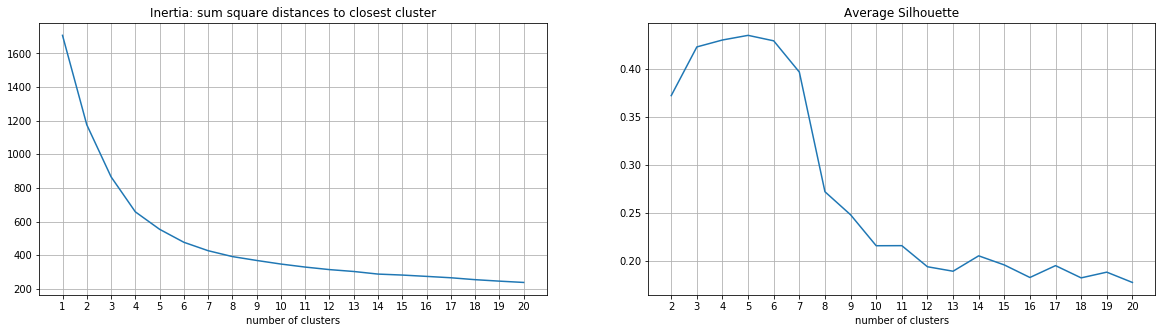

In [22]:
#keep track of inertia values
inertia = []

#keep track of silhouette values
silhouette = []

#number of clusters we are testing
clusters = 20


# X is our transposed data set
for i in np.arange(1,clusters+1):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(X)  
    
    inertia_i = kmeans.inertia_
    inertia = inertia + [inertia_i]
    
    if i>1:
        silhouette_i = silhouette_score(X, kmeans.labels_)
        silhouette = silhouette + [silhouette_i]
        
#plotting our measures

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Inertia: sum square distances to closest cluster")
plt.plot(np.arange(1,clusters+1),inertia)
plt.xticks(np.arange(1,clusters+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,2,2)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,clusters+1), silhouette)
plt.xticks(np.arange(2,clusters+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

The maximum of the average silhouette tells us that the best value of clusters is somewhere between 4-6, and the values right before the slow decline of the inertia are 5 or 6. The average silhouettes between 5 and 6 are very close, meaning the distance between clusters are roughly the same. The inertia of 6 is noticably smaller than 5, meaning that the points within a cluster are closer together than 5. So based on the inertia and silhouette the number of clusters to use is 6 clusters.

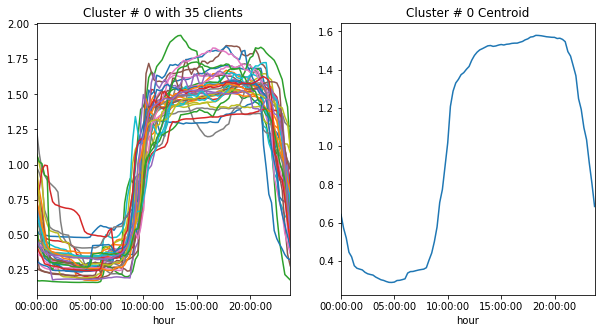

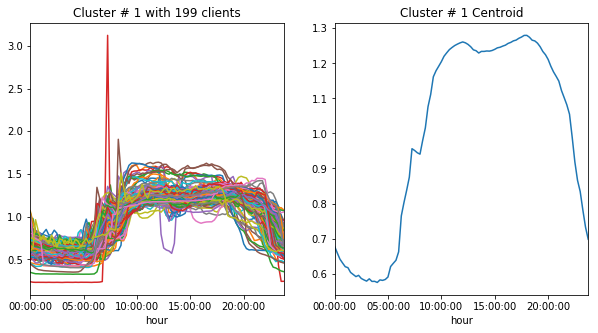

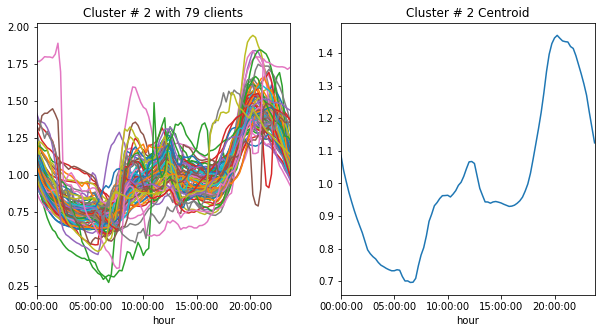

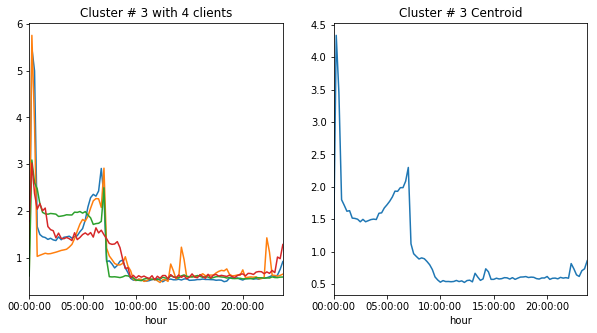

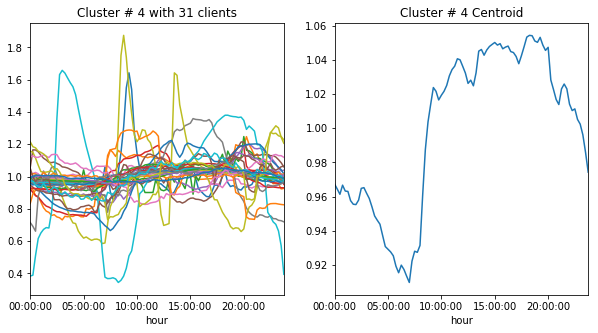

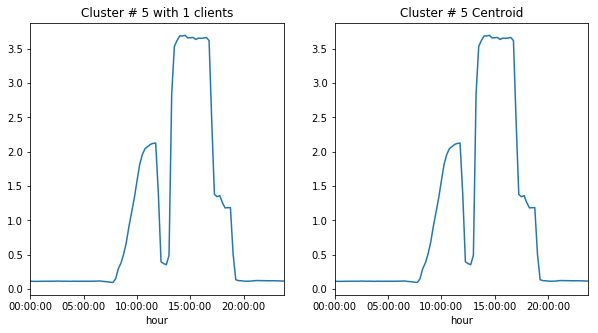

In [26]:
#fit our KMeans model to X
km = KMeans(n_clusters = 6, random_state = 42)
km.fit(X)

#labels tell us where each datapiece belongs, then np.unique gives us the label values + counts
cluster_counts = np.unique(km.labels_, return_counts = True)


for i in cluster_counts[0]:
    plt.figure(figsize=(10,5))
    
    #find the index of where each client has been clustered
    index_X = np.where(km.labels_ == i)[0]
    #index the columns to find clients, we get a dataframe and we plot the dataframe
    ax1 = plt.subplot(1,2,1)
    
    average_curves_norm.iloc[:,index_X].plot(legend=False, ax=ax1)
    plt.title("Cluster # %i with %i clients"%(i,cluster_counts[1][i]))
    
    #plot for only centroid
    ax2 = plt.subplot(1,2,2)
    
    pd.Series(data = km.cluster_centers_[i], index = average_curves_norm.index).plot(ax=ax2)
    plt.title("Cluster # %i Centroid"%(i))
    
    plt.show()

### Part 2

This exercise is similar to part one, but this time we will use only the energy usage curves of a single client. This will give us 730 arrays of normalized curves, one for each day in 2013 and 2014. We will determine the optimal value for k-means and then determine what each cluster represents.

In [27]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])

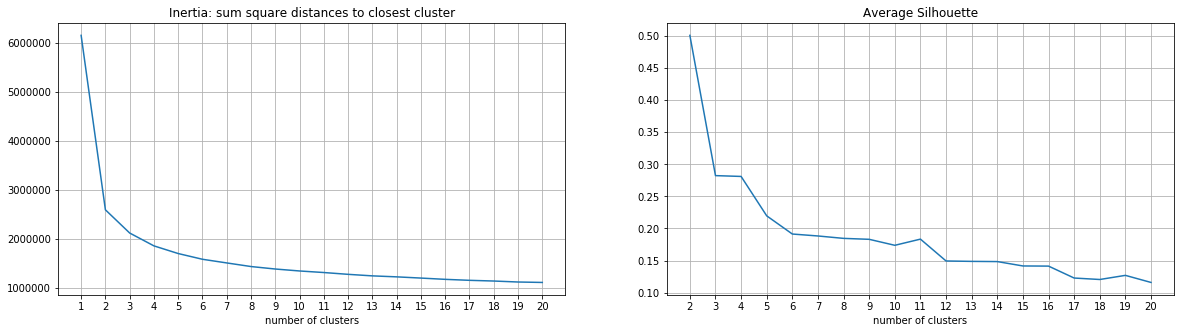

In [28]:
#optimal value for k-means


#keep track of inertia values
inertia = []

#keep track of silhouette values
silhouette = []

#number of clusters we are testing
clusters = 20

for i in np.arange(1,clusters+1):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(X)  
    
    inertia_i = kmeans.inertia_
    inertia = inertia + [inertia_i]
    
    if i>1:
        silhouette_i = silhouette_score(X, kmeans.labels_)
        silhouette = silhouette + [silhouette_i]
        
#plotting our measures

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Inertia: sum square distances to closest cluster")
plt.plot(np.arange(1,clusters+1),inertia)
plt.xticks(np.arange(1,clusters+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,2,2)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,clusters+1), silhouette)
plt.xticks(np.arange(2,clusters+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

According to our inertia and silhouette plots, the optimal number of clusters for k-means is 2, providing the best balance of distance between clusters and distance of points from centroid.

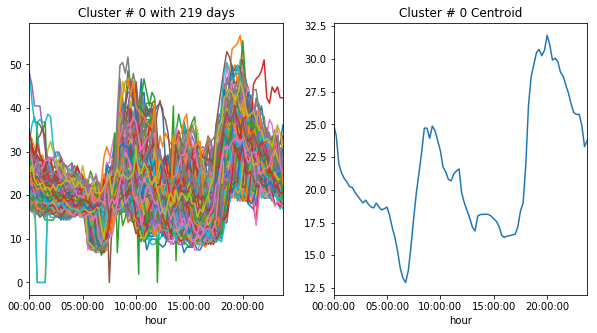

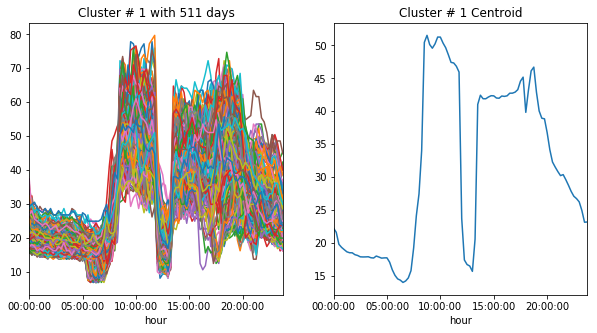

In [29]:
#fit our KMeans model to X
km = KMeans(n_clusters = 2, random_state = 42)
km.fit(X)

#labels tell us where each datapiece belongs, then np.unique gives us the label values + counts
cluster_counts = np.unique(km.labels_, return_counts = True)

cluster_counts

for i in cluster_counts[0]:
    plt.figure(figsize=(10,5))
    
    #find the index of where each day has been clustered
    index_X = np.where(km.labels_ == i)[0]
    #index the columns to find days, we get a dataframe and we plot the dataframe
    ax1 = plt.subplot(1,2,1)
    
    pd.DataFrame(data = np.array(X)[index_X].T, index = average_curves_norm.index).plot(ax=ax1, legend=False)
    
    plt.title("Cluster # %i with %i days"%(i,cluster_counts[1][i]))
    
    #plot for only centroid
    ax2 = plt.subplot(1,2,2)
    
    pd.Series(data = km.cluster_centers_[i], index = average_curves_norm.index).plot(ax=ax2)
    plt.title("Cluster # %i Centroid"%(i))
    
    plt.show()

The clusters obtainedrepresent the pattern of energy usage over the day. There are two different types of days with very similar patterns, so one cluster appears to be weekdays and the other weekends. Over two years, there are 52x2x2 = 208 weekend days and 52x5x2 = 520 weekday days, and if we include holidays then this corresponds to our days in each cluster.